# **NOTE for Colab Users**

# **Do NOT write directly in this file—your work might be lost!**

# **Always make a copy before you start.**

How to make a copy

1. Click "File" in the top left.
> *If you can’t find the header (like “File” or "Runtime"), click the “v” mark at the top right to show it.*

2. "Save a copy in Drive"

3. Change the copied file’s name to “YOURNAMEs\_FileName.ipynb”.
> Ex: If your name is Olivia : Olivias_FileName.ipynb

4. Set your runtime to **CPU**. T4 GPU resets your session more often than CPU.<br>
So, it’s best to use the CPU runtime unless you need GPU for training.<br>
Check out this [Video](https://youtu.be/XRmI-qRiFFw).<br>

> If you switch the runtime halfway, you have to rerun all cells from the start.<br>
> Please pick your runtime before you begin.<br>
> *Rerunning cells: Click “Runtime” (top left) → Then click “Run before”.*<br>

---

* Check marks (✅) won’t be saved. If you reload the page with Chrome’s refresh button, they’ll disappear.<br>
If you want to pause and come back later, just add a text cell and write something like “SO FAR DONE.”

---

* In Colab, **previous outputs reset every 30 to 90 minutes**.<br>
  Because of this, errors like `~~ is not defined` will happen **very often**.

  🔁 What to do when you get an `~~is not defined` error
  1. First, make sure your variable is spelled right.<br>
  2. If it’s spelled right but you still see the error, **click the cell you want to restart**.<br>
  3. Go to “Runtime” (top left) → Click “Run before”.<br>
    → This will **re-run all previous cells**.
  4. Run the cell again.

  If you still see the error after these steps,<br>
  there might be a basic mistake in your TODO answers from earlier cells.<br>
  Please check if your answer is right.<br>
  Or ask ChatGPT or another coding assistant for help.

# **Preparation**

This section only loads content from earlier chapters.<br>
Just run the code—you don’t need to read it.<br>
Feel free to skip ahead.<br>

In [ ]:
# Donwload the file
!wget https://raw.githubusercontent.com/HayatoHongo/Everyones_nanoGPT/main/input.txt -O input.txt
# Load the file called input.text that you just downloaded in utf-8.
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

# A Function to Display Tensors Nicely (Feel Free to Skip This)
import torch
import torch.nn as nn
import torch.nn.functional as F

def print_formatted_tensor(*args, width=6, decimals=2):
    """
    A function that neatly formats and displays a PyTorch Tensor, and also prints its size.

    Example usage:
        print_formatted_tensor("name", tensor)
        print_formatted_tensor(tensor)

    Args:
        *args: If given 1 argument, it is treated as a tensor.
               If given 2 arguments, the first is treated as the name, the second as the tensor.
        width (int): Display width for each number (default: 6)
        decimals (int): Number of decimal places to show (default: 2)
    """

    # Determine tensor and name from arguments
    if not args:
        raise ValueError("At least one argument is required.")
    if isinstance(args[0], str):
        if len(args) < 2:
            raise ValueError("Tensor is not specified.")
        name, tensor = args[0], args[1]
    else:
        name, tensor = None, args[0]

    # Convert Tensor to List
    tensor_list = tensor.detach().cpu().tolist()

    def format_list(lst, indent):
        """Formatting a recursively nested list and returning a string"""
        # If the contents are lists, then re-return
        if isinstance(lst, list) and lst and isinstance(lst[0], list):
            inner = ",\n".join(" " * indent + format_list(sub, indent + 2) for sub in lst)
            return "[\n" + inner + "\n" + " " * (indent - 2) + "]"
        # For numerical lists
        return "[" + ", ".join(f"{v:{width}.{decimals}f}" for v in lst) + "]"

    # Formatted string (bar brackets on outermost frames are removed)
    formatted = format_list(tensor_list, indent=9)
    inner_formatted = formatted[1:-1].strip()

    # Result output
    if name:
        print(name)
    print(f"Tensor Size: {list(tensor.size())}")
    print("tensor([")
    print(" " * 9 + inner_formatted)
    print(" " * 7 + "])")

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # Define an embedded table for vocabulary number x number of embedding dimensions
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)

    def embed(self, input_indices):
        # Get the embedded vector corresponding to the input index
        return self.token_embedding_table.forward(input_indices)

# Defining a Position Embedded Module
class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length, embedding_dim):
        super().__init__()
        # Location embedding layer
        self.position_embedding_layer = nn.Embedding(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        sequence_length = input_indices.shape[1]  # Get sequence length
        position_indices = torch.arange(sequence_length, device=input_indices.device)  # Position index generation
        position_embeddings = self.position_embedding_layer(position_indices)  # Position embedding
        return position_embeddings

class EmbeddingModule(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # Embedded layer for each token
        self.token_embedding_layer = TokenEmbedding(vocab_size = vocab_size, embedding_dim = config.embedding_dim)
        self.position_embedding_layer = PositionEmbedding(input_sequence_length = config.input_sequence_length, embedding_dim = config.embedding_dim)

    def forward(self, input_indices):
        # Get token embedding
        token_embeddings = self.token_embedding_layer.embed(input_indices)

        # Get location embedding
        position_embeddings = self.position_embedding_layer.forward(input_indices)

        # Adding token embedding and position embedding
        embeddings = token_embeddings + position_embeddings
        return embeddings


class AttentionHead(nn.Module):
    def __init__(self, head_size, config):
        super().__init__()
        self.key_fc= nn.Linear(config.embedding_dim, head_size, bias=False)
        self.query_fc = nn.Linear(config.embedding_dim, head_size, bias=False)
        self.value_fc = nn.Linear(config.embedding_dim, head_size, bias=False)

        # Masks are created using the lower triangular matrix (maintaining the causality of self-attention)
        self.register_buffer('tril', torch.tril(torch.ones(config.input_sequence_length, config.input_sequence_length)))

        # Dropout
        self.dropout = DeterministicDropout(config.dropout_rate)
        self.head_size = head_size

    def forward(self, input_tensor):
        B, T, C = input_tensor.shape  # Batch, Token Length, Embedding Channel

        key = self.key_fc.forward(input_tensor)     # (B, T, head_size)
        query = self.query_fc.forward(input_tensor)   # (B, T, head_size)
        value = self.value_fc.forward(input_tensor)   # (B, T, head_size)

        # Calculating Attention score (QK^T) * self.head_size **(-0.5)
        attention_scores = query @ key.transpose(-2, -1) * self.head_size**(-0.5)

        # Mask applied
        attention_scores = attention_scores.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        # Softmax → Dropout → Weighted sum
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        out = attention_weights @ value  # (B, T, head_size)
        return out

class DeterministicDropout(nn.Module):
    def __init__(self, p=0.1, seed=199):
        super().__init__()
        self.p = p
        # Create a fixed random number generator
        self.generator = torch.Generator()
        self.generator.manual_seed(seed)

    def forward(self, x):
        if self.training:
            # Generate random numbers using a fixed generator
            mask = (torch.rand(x.shape, generator=self.generator, device=x.device, dtype=x.dtype) > self.p)
            return x * mask / (1 - self.p)
        else:
            return x

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_attention_heads = config.num_attention_heads
        self.embedding_dim = config.embedding_dim

        # Head size is the number of embedded dimensions // number of AttentionHeads. In this example, 8/2 = 4 is self.head_size.
        self.head_size = int(self.embedding_dim / self.num_attention_heads)

        # Manage multiple heads with ModuleList
        self.attention_heads = nn.ModuleList([
            AttentionHead(self.head_size, config)
            for _ in range(self.num_attention_heads)
        ])

        # Linear layer for mixing the outputs of each head
        self.output_projection = nn.Linear(self.embedding_dim, self.embedding_dim)

        # Dropouts for output
        self.dropout = DeterministicDropout(config.dropout_rate)

    def forward(self, input_tensor):
        # Get output from each head
        head_outputs_list = [head(input_tensor) for head in self.attention_heads]  # List of (B, T, head_dim)

        # Concatenate outputs of all heads → (B, T, embedding_dim)
        concatenated = torch.cat(head_outputs_list, dim=-1)

        # Mixing outputs with linear transformation
        projected = self.output_projection(concatenated)

        # Apply dropout to final output
        output = self.dropout(projected)

        return output


# Configuration class that stores model settings
class ModelConfig:
    batch_size = 1  # Number of data to process at a time (batch size)
    input_sequence_length = 8  # Length of input data (sequence length)
    embedding_dim = 8  # Embedded layer size (number of dimensions of feature vectors)
    num_attention_heads = 2  # Note Mechanism Head Number
    dropout_rate = 0.1  # Dropout probability

torch.manual_seed(1337)

# Creating a ModelConfig instance. No configuration parameters (constructors).
config = ModelConfig()

# Creating an EmbeddingModule instance.
embedding_module = EmbeddingModule(vocab_size = 65, config = config)
layer_norm = nn.LayerNorm(config.embedding_dim)
multiheadattention = MultiHeadAttention(config = config)

# Compatible with Let's he. (Batch size, token length) = (1, 8)
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])

embeddings = embedding_module.forward(sample_input_tokens)
norm_embeddings = layer_norm(embeddings)
multihead_attention_output = multiheadattention.forward(norm_embeddings)
residual_connection_output = multihead_attention_output + embeddings
print_formatted_tensor("residual_connection_output", residual_connection_output)

--2025-07-07 10:08:48--  https://raw.githubusercontent.com/HayatoHongo/nanoGPT_todo/main/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2025-07-07 10:08:48 (17.6 MB/s) - ‘input.txt’ saved [1115394/1115394]

residual_connection_output
Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.24,  -1.89,   2.99,   0.30,   2.23,   0.14,   0.54,   0.06],
           [ -0.53,  -1.24,   0.02,  -0.04,  -1.61,   0.18,   2.44,  -1.22],
           [ -0.93,  -0.31,  -1.88,  -1.09,   2.24,   1.47,  -0.31,  -0.01],
           [ -1.49,  -0.21,   0.49,  -1.53,   0.71,   2.56,  -0.69,  -0.94],
           [ -1.84,  -0.04,  -0.63,  -0

# **Chapter 8: FeedForward**

### **Section 1: __init__**

```python
Instance: layer_norm2 = nn.LayerNorm(embedding_dim)
```

- The input tensor `residual_connection_output` shape is (batch size, token length, embedding dimension) = (1, 8, 8).<br>
Create a Layer Normalization that applies normalization.

In [ ]:
embedding_dim = 8
layer_norm2 = nn.LayerNorm(embedding_dim) # TODO: Make LayerNorm Instance

**`Chapter 8: FeedForward Class: Section 1: init`** <label><input type="checkbox"> Mark as Done</label>

### **Section 2: Forward**

```python
Instance: layer_norm
Method: THINK_FOR_YOURSELF
Argument: residual_connection_output
```

- `layer_norm` applies Layer Normalization to `residual_connection_output`.<br>
It normalizes across the token direction.

In [ ]:
residual_connection_output_norm = layer_norm2.forward(residual_connection_output) # TODO: Instance.Method(Argument)
print_formatted_tensor(residual_connection_output_norm)

Tensor Size: [1, 8, 8]
tensor([
         [
           [ -0.24,  -1.79,   1.75,  -0.20,   1.19,  -0.31,  -0.02,  -0.37],
           [ -0.24,  -0.83,   0.23,   0.18,  -1.14,   0.36,   2.25,  -0.81],
           [ -0.65,  -0.17,  -1.40,  -0.78,   1.85,   1.24,  -0.16,   0.07],
           [ -1.06,  -0.06,   0.49,  -1.09,   0.66,   2.11,  -0.43,  -0.63],
           [ -1.92,  -0.12,  -0.70,  -0.58,   1.29,   1.10,   0.76,   0.17],
           [ -0.15,   1.29,  -1.38,  -0.04,   1.76,  -0.11,  -0.26,  -1.11],
           [ -1.67,  -0.78,   1.02,   0.52,   0.17,   1.45,  -1.03,   0.33],
           [ -0.82,   0.44,   0.09,  -1.66,   0.36,  -0.96,   1.45,   1.10]
         ]
       ])


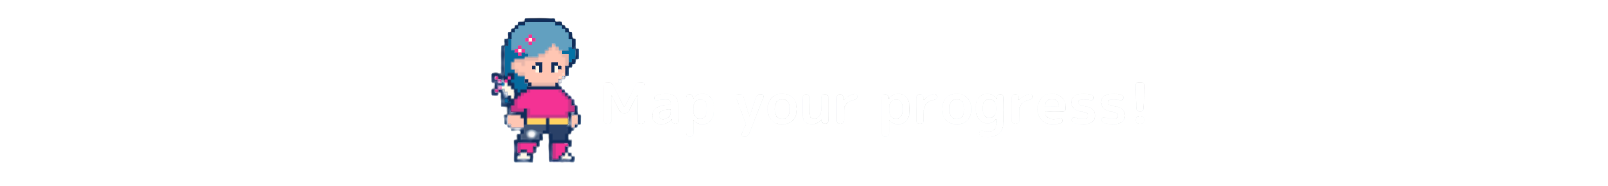

**`Check Point`** <label><input type="checkbox"> ← Check this box if the result above matches the answer below<label>

```
Tensor Size: [1, 8, 8]
tensor([
         [
           [ -0.24,  -1.79,   1.75,  -0.20,   1.19,  -0.31,  -0.02,  -0.37],
           [ -0.24,  -0.83,   0.23,   0.18,  -1.14,   0.36,   2.25,  -0.81],
           [ -0.65,  -0.17,  -1.40,  -0.78,   1.85,   1.24,  -0.16,   0.07],
           [ -1.06,  -0.06,   0.49,  -1.09,   0.66,   2.11,  -0.43,  -0.63],
           [ -1.92,  -0.12,  -0.70,  -0.58,   1.29,   1.10,   0.76,   0.17],
           [ -0.15,   1.29,  -1.38,  -0.04,   1.76,  -0.11,  -0.26,  -1.11],
           [ -1.67,  -0.78,   1.02,   0.52,   0.17,   1.45,  -1.03,   0.33],
           [ -0.82,   0.44,   0.09,  -1.66,   0.36,  -0.96,   1.45,   1.10]
         ]
       ])
```

In [ ]:
# I've just put together the processes so far so I can skip it
torch.manual_seed(1337)

# Creating a ModelConfig instance. No configuration parameters (constructors).
config = ModelConfig()

# Creating an EmbeddingModule instance.
embedding_module = EmbeddingModule(vocab_size = 65, config = config)
layer_norm1 = nn.LayerNorm(config.embedding_dim)
layer_norm2 = nn.LayerNorm(config.embedding_dim)
multiheadattention = MultiHeadAttention(config = config)

# Compatible with Let's he. (Batch size, token length) = (1, 8)
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])

sample_embeddings = embedding_module.forward(sample_input_tokens)
norm_embeddings = layer_norm1(sample_embeddings)
multihead_attention_output = multiheadattention.forward(norm_embeddings)
residual_connection_output = multihead_attention_output + embeddings
residual_connection_output_norm = layer_norm2(residual_connection_output)
print_formatted_tensor("residual_connection_output_norm", residual_connection_output_norm)

residual_connection_output_norm
Tensor Size: [1, 8, 8]
tensor([
         [
           [ -0.24,  -1.79,   1.75,  -0.20,   1.19,  -0.31,  -0.02,  -0.37],
           [ -0.24,  -0.83,   0.23,   0.18,  -1.14,   0.36,   2.25,  -0.81],
           [ -0.65,  -0.17,  -1.40,  -0.78,   1.85,   1.24,  -0.16,   0.07],
           [ -1.06,  -0.06,   0.49,  -1.09,   0.66,   2.11,  -0.43,  -0.63],
           [ -1.92,  -0.12,  -0.70,  -0.58,   1.29,   1.10,   0.76,   0.17],
           [ -0.15,   1.29,  -1.38,  -0.04,   1.76,  -0.11,  -0.26,  -1.11],
           [ -1.67,  -0.78,   1.02,   0.52,   0.17,   1.45,  -1.03,   0.33],
           [ -0.82,   0.44,   0.09,  -1.66,   0.36,  -0.96,   1.45,   1.10]
         ]
       ])


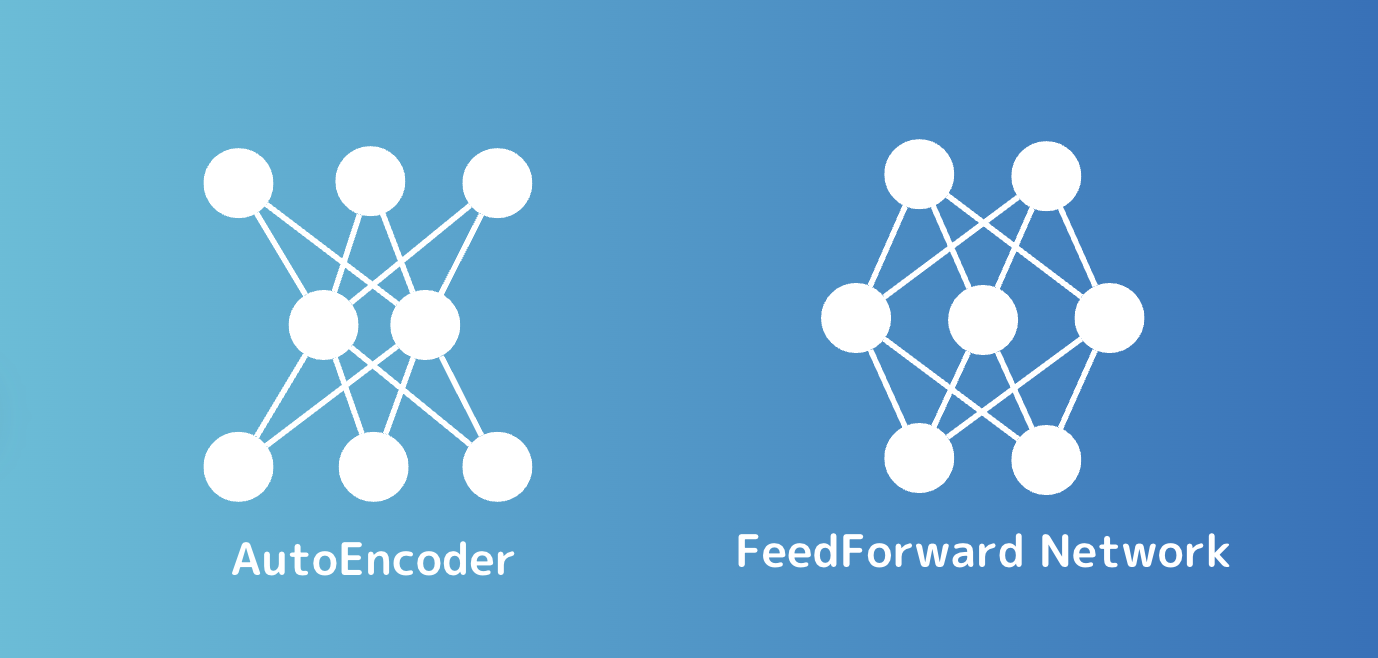

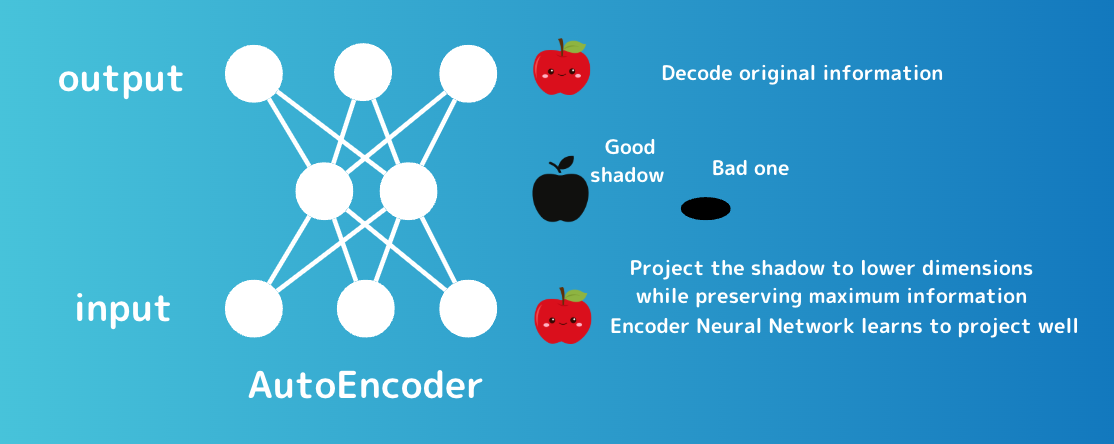

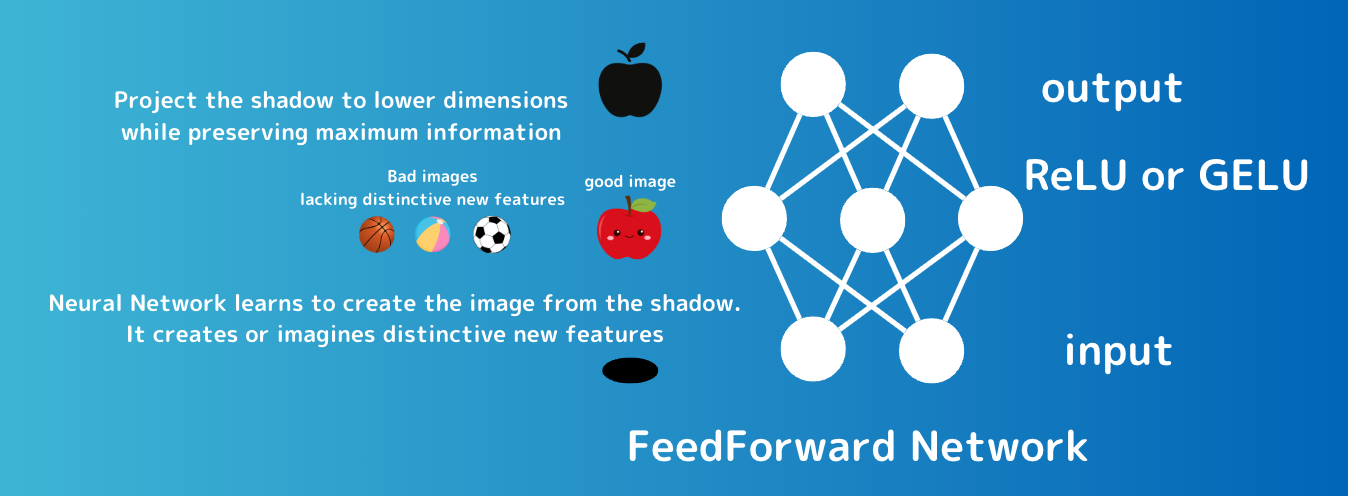

**Understand FeedForward Network in Contrast to AutoEncoder**

---

## FeedForward Network

```
Original-dimension input  
    → higher-dimension projection  
    → non-linear activation  
    → original-dimension projection
```

---

## Why Do This?

* **Richer Representation**

  * Projecting to higher dimensions builds a richer representation.
* **Feature Highlighting**

  * Compressing back highlights features for next-token prediction.
* **Non-linear Filtering**

  * This step refines attention-gathered context—it acts as a non-linear filter.
* **Pattern Extraction**

  * It surfaces useful patterns for prediction.

---

> **NOTE:** Comparing to an autoencoder helps understanding the concept of high-dimensional projection, but their aims are different.
>
> * **Autoencoder**
>
>   * Aims for faithful reconstruction.
> * **Transformer’s FFN**
>
>   * Aims for context understanding and next-token prediction.
>
> So, this comparison is just an example to grasp the high-dimensional projection.


In [ ]:
torch.manual_seed(1337) # Adjust seed value
embedding_module = EmbeddingModule(vocab_size = 65, config = config)
multiheadattention = MultiHeadAttention(config = config)

embedding_dim = 8
hidden_dim = 2 * embedding_dim
fc1_feedforward = nn.Linear(embedding_dim, hidden_dim) # TODO: fully-connected layer of input dimension 8 and output dimension 16.

# Input residual_connection_output_norm into the full-connection layer of the FeedForward layer
fc1_feedforward_output = fc1_feedforward.forward(residual_connection_output_norm)
print_formatted_tensor("fc1_feedforward_output", fc1_feedforward_output)

fc1_feedforward_output
Tensor Size: [1, 8, 16]
tensor([
         [
           [ -0.33,   0.01,  -0.51,  -0.91,  -0.37,   0.21,  -0.36,  -0.52,  -0.64,   0.30,  -0.47,  -0.29,   0.24,   0.97,  -0.11,  -0.62],
           [  1.18,   0.01,   0.99,  -0.76,   0.43,   0.24,   0.52,  -0.30,   0.29,  -0.14,   0.65,  -0.52,   1.35,  -0.22,   0.47,   0.94],
           [  0.06,  -1.36,  -0.84,  -0.84,  -0.28,   0.34,   0.60,  -0.12,  -0.40,   0.55,  -0.15,  -0.24,   0.13,   0.16,  -0.58,  -0.60],
           [  0.03,  -0.92,   0.10,  -0.09,  -0.38,   0.33,   0.25,  -0.67,  -0.27,   0.01,   0.12,  -0.50,   0.20,   0.05,  -0.55,  -0.19],
           [  0.60,  -1.39,  -0.34,  -1.01,  -0.19,   0.06,   0.12,  -0.60,  -0.28,   0.37,   0.31,  -0.48,   0.56,  -0.04,  -0.52,  -0.52],
           [ -0.49,  -0.03,  -0.75,  -0.74,   0.44,   0.16,  -0.21,   0.07,  -0.67,   0.76,  -1.38,   0.24,   0.28,  -0.13,  -0.53,  -0.41],
           [ -0.02,  -0.28,  -0.00,   0.12,  -0.68,   0.30,  -0.38,  -0.93,  -0.92,   0

If the tensor is too large to take a screen-shot, zoom out using Chrome’s zoom feature or take screenshots in two parts.

[Watch Video: How to zoom out ](https://youtu.be/CggFWWtqkHw)

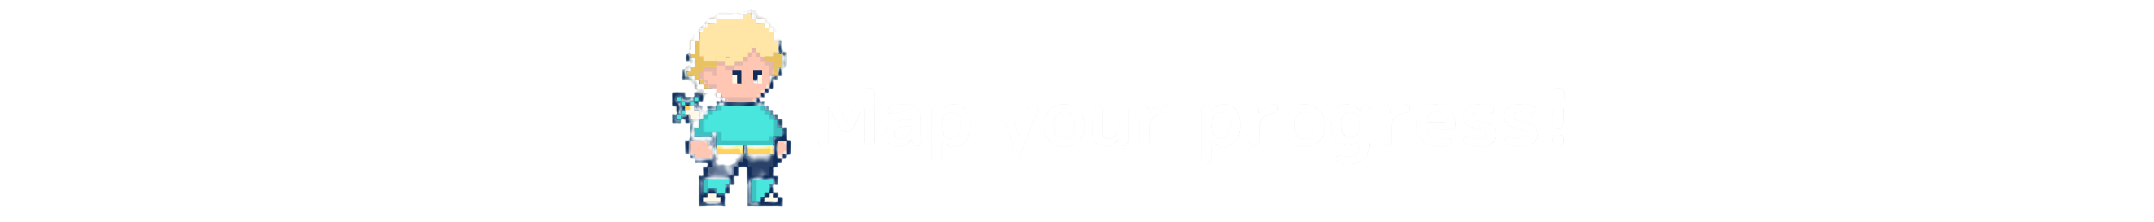

In `MultiHeadAttention`, linear transformations, dot products, and dropout are used, but **no activation functions (non-linear functions) are applied**.  
As it stands, **the output stays just a mix of linear transformations**. This means it can only represent "hyperplanes" (like a line in 1D or a flat surface in 2D).

To add **non-linear power to the model**, the `FeedForward` layer uses a **ReLU function in its middle layer (e.g., 16 dimensions)**.  
This lets the model learn more complex patterns and relationships.<br>


```python
Instance: relu
Method: forward (optional)
Argument: fc1_feedforward_output
```
- Apply the ReLU activation function to the linear transform output.
- Passing through the activation adds nonlinearity.<br>This helps the model learn more complex relationships.

In [ ]:
relu = nn.ReLU()
fc1_feedforward_output_relu = relu.forward(fc1_feedforward_output) # TODO: Instance.Method(Argument)
print_formatted_tensor("fc1_feedforward_output_relu", fc1_feedforward_output_relu)

fc1_feedforward_output_relu
Tensor Size: [1, 8, 16]
tensor([
         [
           [  0.00,   0.01,   0.00,   0.00,   0.00,   0.21,   0.00,   0.00,   0.00,   0.30,   0.00,   0.00,   0.24,   0.97,   0.00,   0.00],
           [  1.18,   0.01,   0.99,   0.00,   0.43,   0.24,   0.52,   0.00,   0.29,   0.00,   0.65,   0.00,   1.35,   0.00,   0.47,   0.94],
           [  0.06,   0.00,   0.00,   0.00,   0.00,   0.34,   0.60,   0.00,   0.00,   0.55,   0.00,   0.00,   0.13,   0.16,   0.00,   0.00],
           [  0.03,   0.00,   0.10,   0.00,   0.00,   0.33,   0.25,   0.00,   0.00,   0.01,   0.12,   0.00,   0.20,   0.05,   0.00,   0.00],
           [  0.60,   0.00,   0.00,   0.00,   0.00,   0.06,   0.12,   0.00,   0.00,   0.37,   0.31,   0.00,   0.56,   0.00,   0.00,   0.00],
           [  0.00,   0.00,   0.00,   0.00,   0.44,   0.16,   0.00,   0.07,   0.00,   0.76,   0.00,   0.24,   0.28,   0.00,   0.00,   0.00],
           [  0.00,   0.00,   0.00,   0.12,   0.00,   0.30,   0.00,   0.00,   0.00

If the tensor is too large to take a screen-shot, zoom out using Chrome’s zoom feature or take screenshots in two parts.

[Watch Video: How to zoom out ](https://youtu.be/CggFWWtqkHw)

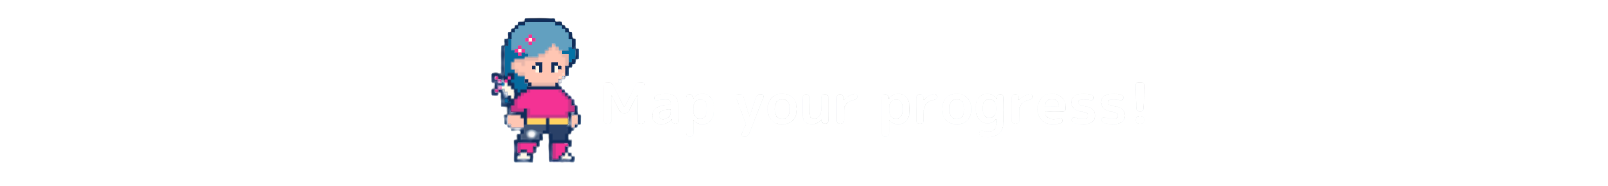

```python
Instance: fc2_feedforward = nn.Linear(input_dim, output_dim)
input_dim: The dimension size of the hidden layer
output_dim: The original dimension size
```


In [ ]:
torch.manual_seed(1337) # Adjust seed value
embedding_module = EmbeddingModule(vocab_size = 65, config = config) # Don't worry as it's just defined to adjust seed values.
multiheadattention = MultiHeadAttention(config = config)
fc1_feedfowward = nn.Linear(embedding_dim, hidden_dim)

fc2_feedforward = nn.Linear(hidden_dim, embedding_dim) # TODO: Apply nn.Linear (input dimension, output dimension)

fc2_feedforward_output = fc2_feedforward.forward(fc1_feedforward_output_relu)
print_formatted_tensor("fc2_feedforward_output", fc2_feedforward_output)

fc2_feedforward_output
Tensor Size: [1, 8, 8]
tensor([
         [
           [ -0.09,  -0.27,  -0.10,   0.22,   0.14,   0.42,   0.15,  -0.20],
           [  0.08,  -0.37,   0.19,   0.57,  -0.21,   0.64,   0.09,  -0.19],
           [ -0.05,  -0.22,  -0.20,  -0.08,  -0.09,   0.29,   0.21,   0.11],
           [  0.06,  -0.25,  -0.09,   0.07,  -0.16,   0.29,   0.21,   0.02],
           [  0.17,  -0.10,   0.09,   0.04,  -0.02,   0.45,   0.10,   0.03],
           [ -0.08,  -0.13,  -0.01,   0.00,   0.13,   0.42,   0.24,   0.15],
           [  0.00,  -0.16,  -0.06,   0.03,   0.01,   0.29,   0.21,   0.08],
           [  0.16,  -0.13,  -0.16,   0.61,   0.08,   0.41,   0.12,  -0.46]
         ]
       ])


**`Check Point`** <label><input type="checkbox"> ← Check this box if the result above matches the answer below<label>

```
fc2_feedforward_output
Tensor Size: [1, 8, 8]
tensor([
         [
           [ -0.09,  -0.27,  -0.10,   0.22,   0.14,   0.42,   0.15,  -0.20],
           [  0.08,  -0.37,   0.19,   0.57,  -0.21,   0.64,   0.09,  -0.19],
           [ -0.05,  -0.22,  -0.20,  -0.08,  -0.09,   0.29,   0.21,   0.11],
           [  0.06,  -0.25,  -0.09,   0.07,  -0.16,   0.29,   0.21,   0.02],
           [  0.17,  -0.10,   0.09,   0.04,  -0.02,   0.45,   0.10,   0.03],
           [ -0.08,  -0.13,  -0.01,   0.00,   0.13,   0.42,   0.24,   0.15],
           [  0.00,  -0.16,  -0.06,   0.03,   0.01,   0.29,   0.21,   0.08],
           [  0.16,  -0.13,  -0.16,   0.61,   0.08,   0.41,   0.12,  -0.46]
         ]
       ])
```

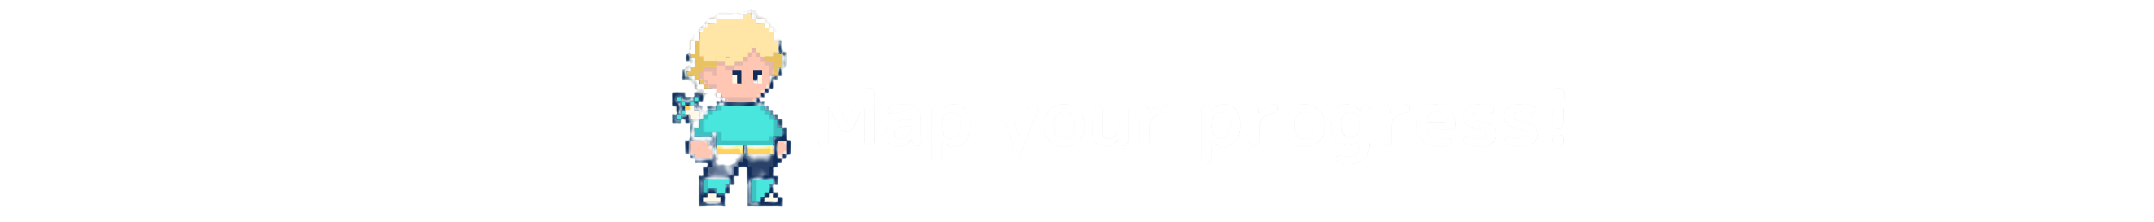

```python
Instance: dropout
Method: forward (optional)
Argument: fc2_feedforward_output
```

In [ ]:
dropout = DeterministicDropout()
fc2_feedforward_output_dropout = dropout.forward(fc2_feedforward_output) # TODO: Apply instance.Method(argument)
print_formatted_tensor("fc2_feedforward_output_dropout", fc2_feedforward_output_dropout)

fc2_feedforward_output_dropout
Tensor Size: [1, 8, 8]
tensor([
         [
           [ -0.10,  -0.29,  -0.12,   0.25,   0.16,   0.00,   0.16,  -0.22],
           [  0.09,  -0.41,   0.21,   0.63,  -0.23,   0.71,   0.10,  -0.22],
           [ -0.06,  -0.25,  -0.22,  -0.09,  -0.10,   0.32,   0.23,   0.12],
           [  0.07,  -0.28,  -0.10,   0.08,  -0.17,   0.32,   0.23,   0.00],
           [  0.19,  -0.11,   0.10,   0.00,  -0.02,   0.50,   0.00,   0.04],
           [ -0.09,  -0.00,  -0.00,   0.00,   0.14,   0.46,   0.27,   0.16],
           [  0.01,  -0.18,  -0.06,   0.03,   0.01,   0.33,   0.23,   0.09],
           [  0.18,  -0.15,  -0.00,   0.68,   0.09,   0.45,   0.13,  -0.51]
         ]
       ])


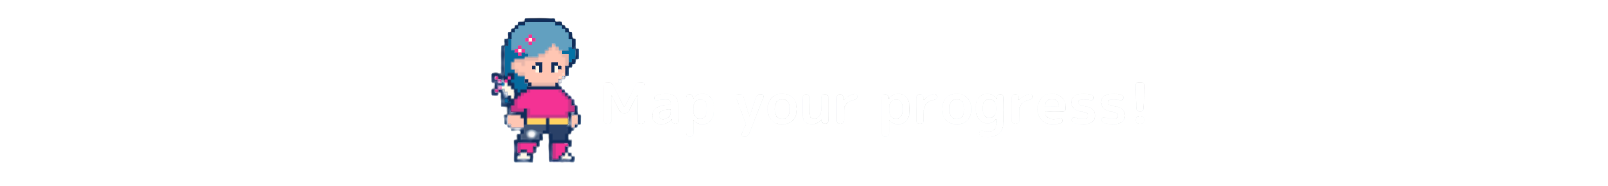

**`Chapter 8: FeedForward Class: Section 2: forward`** <label><input type="checkbox"> Mark as Done</label>

### **Section 3: Define a Class**

🔘 **Options**: There may be extra options you don't need.

`config.input_sequence_length`　　`config.embedding_dim`　　`config.hidden_dim`　　`nn.Linear`　　`nn.ReLU()`　　`config.dropout_rate`　　`input_tensor`

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.embedding_dim, config.hidden_dim),
            nn.ReLU(),
            nn.Linear(config.hidden_dim, config.embedding_dim),
            DeterministicDropout(config.dropout_rate),
        )

    def forward(self, input_tensor):
        return self.net(input_tensor)

In [ ]:
"""
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(_____________, _____________),
            _________,
            nn.Linear(_____________, _____________),
            DeterministicDropout(_____________),
        )

    def forward(self, input_tensor):
        return self.net(___________)
"""

'\nclass FeedForward(nn.Module):\n    def __init__(self, config):\n        super().__init__()\n        self.net = nn.Sequential(\n            nn.Linear(_____________, _____________),\n            _________,\n            nn.Linear(_____________, _____________),\n            DeterministicDropout(_____________),\n        )\n\n    def forward(self, input_tensor):\n        return self.net(___________)\n'

<details>
<summary>Click here to show/hide answer</summary>

```python
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.embedding_dim, config.hidden_dim),
            nn.ReLU(),
            nn.Linear(config.hidden_dim, config.embedding_dim),
            DeterministicDropout(config.dropout_rate),
        )

    def forward(self, input_tensor):
        return self.net(input_tensor)
```

In [ ]:
# Configuration class that stores model settings
class ModelConfig:
    batch_size = 1  # Number of data to process at a time (batch size)
    input_sequence_length = 8  # Length of input data (sequence length)
    embedding_dim = 8  # Embedded layer size (number of dimensions of feature vector)
    hidden_dim = 16 # Hidden layer size in FeedForward layer
    num_attention_heads = 2  # Note Mechanism Head Number
    dropout_rate = 0.1  # Dropout probability

# Verify your settings
config = ModelConfig()

In [ ]:
# I've just put together the processes so far so I can skip it
torch.manual_seed(1337)

# Creating a ModelConfig instance. No configuration parameters (constructors).
config = ModelConfig()

# Creating an EmbeddingModule instance.
embedding_module = EmbeddingModule(vocab_size = 65, config = config)
layer_norm1 = nn.LayerNorm(config.embedding_dim)
layer_norm2 = nn.LayerNorm(config.embedding_dim)
multiheadattention = MultiHeadAttention(config = config)
feedforward = FeedForward(config = config) # TODO: Create a FeedForward instance.

# Compatible with Let's he. (Batch size, token length) = (1, 8)
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])

embeddings = embedding_module.forward(sample_input_tokens)
norm_embeddings = layer_norm1(embeddings)
multihead_attention_output = multiheadattention.forward(norm_embeddings)
residual_connection_output = multihead_attention_output + embeddings
residual_connection_output_norm = layer_norm2(residual_connection_output)
feedforward_output = feedforward.forward(residual_connection_output_norm) # TODO: Instance.Method(Argument)
print_formatted_tensor("feedforward_output", feedforward_output)

feedforward_output
Tensor Size: [1, 8, 8]
tensor([
         [
           [ -0.10,  -0.29,  -0.12,   0.25,   0.16,   0.00,   0.16,  -0.22],
           [  0.09,  -0.41,   0.21,   0.63,  -0.23,   0.71,   0.10,  -0.22],
           [ -0.06,  -0.25,  -0.22,  -0.09,  -0.10,   0.32,   0.23,   0.12],
           [  0.07,  -0.28,  -0.10,   0.08,  -0.17,   0.32,   0.23,   0.00],
           [  0.19,  -0.11,   0.10,   0.00,  -0.02,   0.50,   0.00,   0.04],
           [ -0.09,  -0.00,  -0.00,   0.00,   0.14,   0.46,   0.27,   0.16],
           [  0.01,  -0.18,  -0.06,   0.03,   0.01,   0.33,   0.23,   0.09],
           [  0.18,  -0.15,  -0.00,   0.68,   0.09,   0.45,   0.13,  -0.51]
         ]
       ])


Residual Connection

- A residual connection adds the original input, `residual_connection_output`, to the output of the FeedForward layer, `feedforward_output`.
- A residual connection lets the model learn small changes instead of big shifts.

In [ ]:
# Addition by residual connection
transformer_output = residual_connection_output + feedforward_output # TODO: Adding a residual_connection_output to feedforward_output
print_formatted_tensor("residual_connection_output", transformer_output)

residual_connection_output
Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.14,  -2.19,   2.87,   0.55,   2.39,   0.14,   0.70,  -0.16],
           [ -0.45,  -1.65,   0.23,   0.60,  -1.84,   0.89,   2.54,  -1.43],
           [ -0.99,  -0.56,  -2.10,  -1.18,   2.15,   1.79,  -0.08,   0.11],
           [ -1.42,  -0.49,   0.39,  -1.45,   0.54,   2.88,  -0.46,  -0.94],
           [ -1.65,  -0.16,  -0.53,  -0.51,   1.34,   1.68,   0.84,   0.29],
           [ -0.07,   1.28,  -1.05,   0.13,   1.84,   0.53,   0.20,  -0.65],
           [ -1.80,  -0.87,   1.51,   0.97,   0.52,   2.43,  -0.77,   0.79],
           [ -0.59,   0.51,   0.26,  -1.04,   0.67,  -0.47,   1.94,   0.89]
         ]
       ])


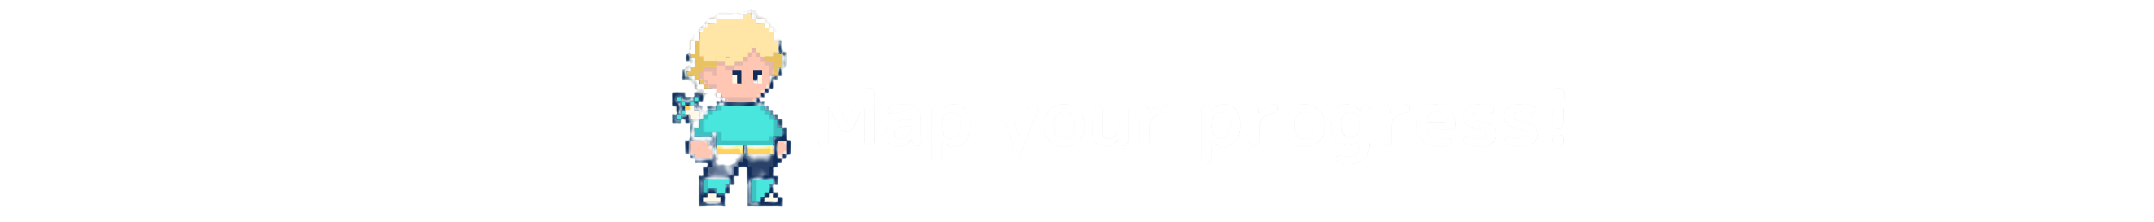

**`Chapter 8: FeedForward Class: Section 3: Define a Class`** <label><input type="checkbox"> Mark as Done</label>

**`Chapter 8: FeedForward Class`** <label><input type="checkbox"> Mark as Done</label>